# Univariate LSTM  

In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow import keras

In [2]:
path = os.getcwd()
path = path.replace('modeling', 'data_preprocessing')
files = os.listdir(path)
for file in files:
    if len(file.split('.csv'))>1:
        csv_path = path+'/'+file
data = pd.read_csv(csv_path)
data['date']=pd.to_datetime(data['date'])

In [3]:
# Univariate data
uv_data = data[data.columns[:2]].set_index(data.columns[0])
uv_data =  uv_data.rename(columns = {data.columns[1]:'target'})
uv_data.head(3)

,target
date,
2000-01-01,41.0
2000-02-01,41.0
2000-03-01,45.0


In [4]:
data = np.array(uv_data)
data[:3]

array([[41.],
       [41.],
       [45.]])

In [5]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [6]:
scaled_data, scaler = scale_data(data)

In [7]:
def create_dataset(data, look_back=5, n_features=1):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :n_features])
        y.append(data[i, 0])
    return np.array(X), np.array(y).reshape(len(y),1)

In [8]:
look_back = 24
n_features = 1
X, y = create_dataset(scaled_data, look_back, n_features)

In [9]:
# def train_val_test(X, y, look_back = 5, test_size=12, val_size=12):
#     X_train, y_train = X[:-(test_size+val_size)], y[:-(test_size+val_size)]
#     X_val, y_val = X[-(test_size+val_size+look_back):-(test_size)], y[-(test_size+val_size+look_back):-(test_size)]
#     X_test, y_test = X[-(test_size+look_back):], y[-(test_size+look_back):]
#     display(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
#     return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
def train_val_test(X, y, look_back = 5, test_size=12, val_size=12):
    X_train, y_train = X[:-(test_size+val_size)], y[:-(test_size+val_size)]
    X_val, y_val = X[-(test_size+val_size):-(test_size)], y[-(test_size+val_size):-(test_size)]
    X_test, y_test = X[-(test_size):], y[-(test_size):]
    display(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
test_size = 18
val_size =30
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test(X, y, look_back=look_back, test_size=test_size, val_size=val_size)

(204, 24, 1)

(204, 1)

(30, 24, 1)

(30, 1)

(18, 24, 1)

(18, 1)

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.models import load_model

In [13]:
def lstm_model(X_train, y_train, X_val, y_val, n_features, look_back, batch_size, learning_rate, epochs, stateful=True):
    model = Sequential()
    if stateful:
        model.add(LSTM(units=50, batch_input_shape = (batch_size, look_back, n_features), stateful=stateful))
    else:
        model.add(LSTM(units=50, input_shape = (look_back, n_features)))
    model.add(Dense(1))

    model.summary()

    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    optimizer=Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredError(), optimizer=optimizer, metrics=[RootMeanSquaredError()])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], verbose=0)

    best_train_loss = min(history.history['loss'])
    best_train_rmse = min(history.history['root_mean_squared_error'])
    best_val_loss = min(history.history['val_loss'])
    best_val_rmse = min(history.history['val_root_mean_squared_error'])

    print(f"Best Train loss: {best_train_loss}")
    print(f"Lowest Train RMSE: {best_train_rmse}")
    print(f"Best Train loss: {best_val_loss}")
    print(f"Lowest Train RMSE: {best_val_rmse}")

    return load_model('best_model.h5')

In [14]:
batch_size= 1
learning_rate=  0.001
epochs= 50

model1 = lstm_model(X_train, y_train, X_val, y_val, n_features, look_back, batch_size, learning_rate, epochs, stateful=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 50)                   10400     
                                                                 
 dense (Dense)               (1, 1)                    51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


2023-06-11 23:26:59.268367: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Best Train loss: 0.002221739385277033
Lowest Train RMSE: 0.047135330736637115
Best Train loss: 0.007176890503615141
Lowest Train RMSE: 0.08471652865409851


In [15]:
model2 = lstm_model(X_train, y_train, X_val, y_val, n_features, look_back, batch_size, learning_rate, epochs, stateful=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Best Train loss: 0.002176332753151655
Lowest Train RMSE: 0.04665118083357811
Best Train loss: 0.006859761197119951
Lowest Train RMSE: 0.08282367885112762


In [16]:
#check if model is stateful
def is_lstm_stateful(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.LSTM):
            return layer.stateful
    return None

In [17]:
def make_predictions(X, model):
    stateful = is_lstm_stateful(model)    #check if model was stateful
    if stateful:
        predictions = []
        for i in range(len(X)):
            sample = np.reshape(X[i], (1, look_back, n_features))
            predictions.append(model1.predict(sample))
        predictions = np.array(predictions)
    else:
        predictions = model.predict(X)
    return predictions.reshape(len(predictions),1)

In [18]:
predictions1 = make_predictions(X_test, model1)
predictions2 = make_predictions(X_test, model2)

1/1 [==============================] - 0s 142ms/step


In [19]:
def inverse_predictions(scaled_y):
    y=scaler.inverse_transform(np.hstack((scaled_y, np.zeros((scaled_y.shape[0], uv_data.shape[0]-1)))))[:,0]
    return y

In [20]:
y_test.shape

(18, 1)

In [21]:
y_pred1=inverse_predictions(predictions1)
y_pred2=inverse_predictions(predictions2)
y_test_actual=inverse_predictions(y_test)

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def print_metrics(predictions, actuals):
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    directional_accuracy = np.mean((np.sign(actuals[1:] - actuals[:-1]) == np.sign(predictions[1:] - predictions[:-1]))) *100

    print(f"RMSE: {rmse:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R2: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

In [23]:
print("Stateful Model")
print_metrics(y_pred1, y_test_actual)

Stateful Model
RMSE: 3.18
MSE: 10.08
R2: 0.73
MAE: 2.53
MAPE: 2.57%
Directional Accuracy: 29.41%


In [24]:
print("Stateless Model")
print_metrics(y_pred2, y_test_actual)

Stateless Model
RMSE: 2.27
MSE: 5.17
R2: 0.86
MAE: 1.68
MAPE: 1.70%
Directional Accuracy: 35.29%


In [25]:
compare1 = uv_data[look_back:].copy()
compare1['prediction']=list(inverse_predictions(make_predictions(X, model1)))

1/1 [==============================] - 0s 10ms/step


In [26]:
compare2 = uv_data[look_back:].copy()
compare2['prediction']=list(inverse_predictions(make_predictions(X, model2)))

8/8 [==============================] - 0s 1ms/step


In [27]:
print_metrics(compare1.target, compare1.prediction)

RMSE: 3.96
MSE: 15.69
R2: 0.95
MAE: 2.70
MAPE: 3.76%
Directional Accuracy: 99.21%


In [28]:
print_metrics(compare2.target, compare2.prediction)

RMSE: 3.80
MSE: 14.45
R2: 0.95
MAE: 2.51
MAPE: 3.50%
Directional Accuracy: 99.21%


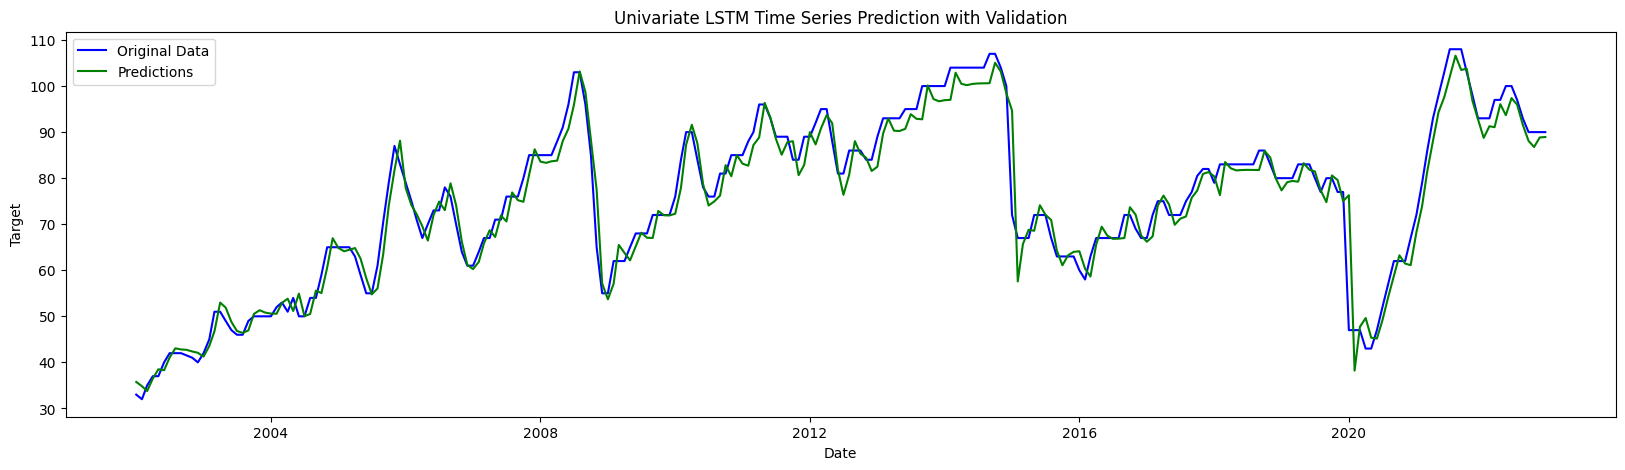

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(compare1.index, compare1['target'], color='blue', label='Original Data')
plt.plot(compare1.index, compare1['prediction'], color='green', label='Predictions')
plt.legend()
plt.title('Univariate LSTM Time Series Prediction with Validation')
plt.xlabel('Date')
plt.ylabel('Target')
plt.show()

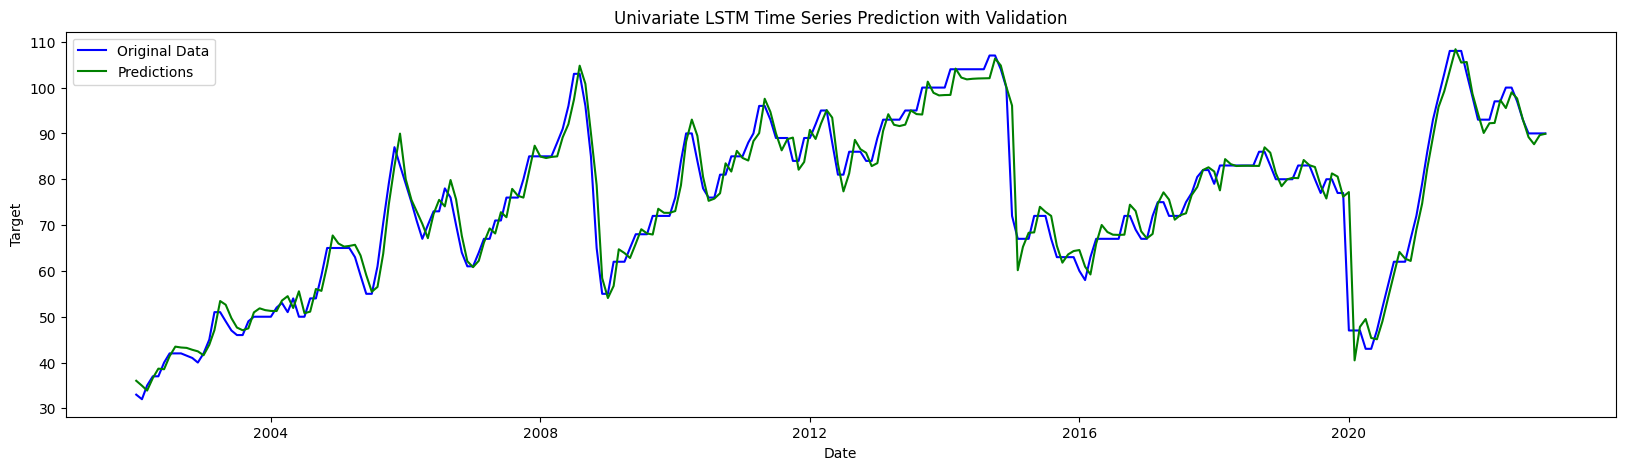

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(compare2.index, compare2['target'], color='blue', label='Original Data')
plt.plot(compare2.index, compare2['prediction'], color='green', label='Predictions')
plt.legend()
plt.title('Univariate LSTM Time Series Prediction with Validation')
plt.xlabel('Date')
plt.ylabel('Target')
plt.show()